# Simple RL code to teach the model to stand

## Setup jax enviroment and Load Model 

In [ ]:
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt

import sys
sys.path.append("../Biodiffrl")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".80"

# Optionally, force JAX to preallocate memory.
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Setup environment variable for Nvidia GPU acceleration
os.environ['XLA_FLAGS'] = (
    # '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    # '--xla_gpu_enable_async_collectives=true '
    # '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
    # '--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32'
)

backend = 'gpu'
# backend = 'METAL'
# backend = 'cpu'

import jax
jax.config.update('jax_platform_name', 'gpu')
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_lazy_compilation=false"
# Enable compliation catch
os.environ["JAX_COMPILATION_CACHE_DIR"] = "./jax_cache"
jax.config.update("jax_compilation_cache_dir", "./jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", 0)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 2)
# jax.config.update("jax_explain_cache_misses", True)

from jax.experimental.compilation_cache import compilation_cache as cc
cc.set_cache_dir("./jax_cache")
# Debug Nan
# jax.config.update("jax_debug_nans", True)

from jax import numpy as jp
# More legible printing from numpy.
jp.set_printoptions(precision=4, suppress=True, linewidth=100)

import mujoco
import mujoco.mjx as mjx
from mujoco.mjx._src import scan
from mujoco.mjx._src import types

# More legible printing from numpy.
np.set_printoptions(precision=4, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

device = jax.devices(backend=backend)[0]

model_path = '/home/bugman/Currentwork/biomujoco_converter/converted/mjc/Gait2354/gait2354_cvt1_easy.xml'

# Single step
mjx_step = jax.jit(mjx.step, backend=backend)



# mjx_multiple_steps = jax.jit(multiple_steps, backend=backend, )

## Load Model

In [ ]:
from mujoco.mjx._src.biomtu import acceleration_mtu

mj_model = mujoco.MjModel.from_xml_path(model_path)
mjx_model = mjx.put_model(mj_model,device=device)

# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)
mjx_data = jax.jit(mjx_step)(mjx_model, mjx_data)

init_mjx_data = mjx_data

def print_all():
    print(mjx_model.biomtu_adr)
    print(mjx_model.mtu_wrap_objid)
    print(mjx_model.mtu_wrap_type)
    print(mjx_model.biomtu_fiso)
    print(mjx_model.biomtu_vmax)
    print(mjx_model.biomtu_ofl)
    print(mjx_model.biomtu_opa)
    print(mjx_model.biomtu_mass)
    print("-------Data--------")
    print("qpos:", mjx_data.qpos)
    print("mtu l:", mjx_data.biomtu.l)
    print("tendon l:", mjx_data.biomtu.tendon_l)
    print("fiber l :", mjx_data.biomtu.fiber_l)
    print("Muscle Bce:", mjx_data.biomtu.B_ce)
    print("Muscle vm:", mjx_data.biomtu.m)
    print("Fiber acc:", mjx_data.biomtu.fiber_acc)
    print("Fiber v:", mjx_data.biomtu.fiber_v)
    print("Biomtu h:", mjx_data.biomtu.h)
    print(mjx_data.biomtu.v)
    print(mjx_data.biomtu.h)  # The constant high of the muscle.
    print(mjx_data.biomtu.pennation_angle)
    print(mjx_data.biomtu.origin_body_id)
    print(mjx_data.biomtu.insertion_body_id)
    print("mtu act:", mjx_data.biomtu.act)
    # print(mjx_data.biomtu.j)
    print(mjx_data.qfrc_biomtu)
    print(mj_model.key_time)
    print(mj_model.key_qpos)
    print(mj_model.key_qvel)

# print_all()

print(mjx_model.nbiomtu)
print(mjx_model.nq)
print(mjx_data.qpos)
print(mjx_data.qvel)

## Neural Networks

## Multi-steps forward simulation

In [ ]:
import exp

# Multiple steps
def step_fn(carry, _):
    model, data= carry
    new_data = mjx.step(model, data)
    new_carry = (model, new_data)
    return new_carry, _

def multiple_steps(model, data):
    init_carry = (model, data)
    y, _ = jax.lax.scan(step_fn, init_carry, None, length=50)
    new_data = y[1]
    return new_data

# For one step
def nn_mjx_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v, data.sensordata])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, act

def nn_mjx_perturbe_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v, data.sensordata])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    xfrc = jax.random.normal(key,(mjx_model.nbody, 6))*1.0
    data = data.replace(xfrc_applied=xfrc)
    new_data = mjx.step(model, data)
    return new_data, new_key, act

@jax.jit
def jit_nn_mjx_one_step_no_random(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v, data.sensordata])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, mean

def nn_step_fn(carry, _):
    nn_params, model, data, key = carry
    new_data, new_key, act = nn_mjx_one_step(nn_params, model, data, key)
    # new_data, new_key, act = nn_mjx_perturbe_one_step(nn_params, model, data, key)
    new_carry = (nn_params, model, new_data, new_key)
    # Calculate reward
    head_height = new_data.sensordata[2]
    state = jp.concat([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v, data.sensordata])
    next_state = jp.concat([new_data.qpos, new_data.qvel, new_data.biomtu.fiber_l, new_data.biomtu.fiber_v, data.sensordata])
    action = act
    # done = head_hight < 1.2
    done = jp.where(head_height <= 1.4, jp.float32(1), jp.float32(0))
    reward = -(head_height-1.63)**2 - done*0.5
    experience = exp.experience(state, next_state, action, reward, done)
    
    return new_carry, experience

@jax.jit
def nn_multi_steps(nn_params, model, data, key):
    # Also deal with the done in the experience pool
    
    repeat_length = 50  # Simulate for 0.1s
    init_carry = (nn_params, model, data, key)
    y, experience = jax.lax.scan(nn_step_fn, init_carry, None, length=repeat_length)
    new_data = y[2]
    new_key = y[3]
    return new_data, new_key, experience

jit_nn_multi_steps = jax.jit(nn_multi_steps)

# @jax.jit
def v_nn_multi_steps(nn_params, model, data, keys):
    return jax.vmap(nn_multi_steps, in_axes=(None, None, 0, 0))(nn_params, model, data, keys)

jit_v_nn_multi_steps = jax.jit(v_nn_multi_steps)

jit_multiple_steps = jax.jit(multiple_steps)


In [ ]:
# DEBUG
print(mjx_data.qfrc_inverse)
print(mjx_data.qfrc_constraint)
print(mjx_model.nq)
joint_id = mujoco.mj_name2id(mj_model, 2, "knee_angle_r")
for i in range(17):
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_JOINT.value, i)
    joint_id = mujoco.mj_name2id(mj_model,  mujoco.mjtObj.mjOBJ_JOINT.value, name)
    print(i, name)
    # print(joint_id)
# joint_id = mujoco.mj_name2id(mj_model,  mujoco.mjtObj.mjOBJ_BODY.value, "ground-plane")
print(joint_id)
print(mujoco.mjtObj.mjOBJ_BODY.value)
print(mujoco.mjtObj.mjOBJ_JOINT.value)
# print(mj_model.names)

print(mjx_data.efc_force.shape)

## Calculate Jacobian

In [97]:

def get_element_name(index):
    return(mjx_model.names[index:].decode('utf-8').split('\x00', 1)[0])
name = get_element_name(mjx_model.name_biomtuadr[19])

print(name)

vas_int_r


In [66]:
mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)
init_mjx_data = mjx_data


# Define the function
def act_knee_force(act, model, data):
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    # data = multiple_steps(model, data)
    data = multiple_steps(model, data)
    return -data.sensordata[4]

jit_g_act_knee_force = jax.jit(jax.grad(act_knee_force))


In [113]:
act = jp.ones(mjx_model.nbiomtu)*0.1
mjx_data = init_mjx_data
mjx_data = mjx_data.replace(biomtu = mjx_data.biomtu.replace(act = act))
for i in range(4000):
    mjx_data = mjx_step(mjx_model, mjx_data)
    
g = jit_g_act_knee_force(act, mjx_model, mjx_data)

print(g)



[ -48.2099   -7.377     6.2945  -16.6321   -2.1085    0.9628   19.5205   -8.9962    4.4042
    0.5732    0.       -4.1304   -0.1026    2.1142    3.3999    0.        0.        0.
   -3.305   -43.3196   95.6176   41.7291  333.5175 -199.006    48.8182    6.2663   -7.5975
   -5.0091    3.3258    1.2639  -40.985    12.0972   -5.4997   -2.8754    0.        3.4404
   -3.4794    1.0035   -0.1344    0.        0.        0.       13.9527   64.1553 -149.4413
  -66.4284 -382.8269  284.4329    0.        0.        0.        0.        0.        0.    ]


---bad---
tib_post_r 333.5175
tib_ant_l 284.43292
med_gas_r 95.61757
---good---
tib_post_l -382.82693
tib_ant_r -199.00598
med_gas_l -149.44131
[22 47 20 46 23 44]


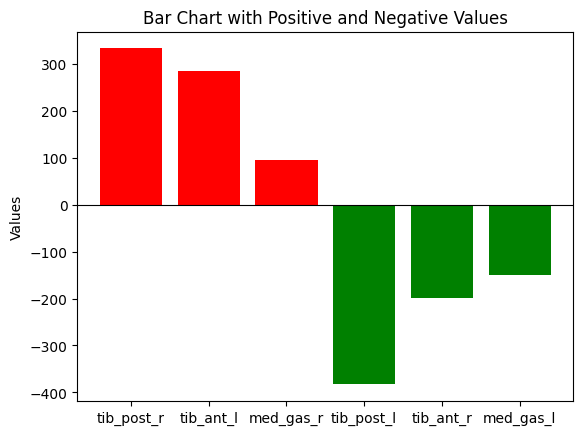

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the largest and the smallest
n_largest = 3

# Get the indices of the n largest elements
indices = np.argpartition(-g, n_largest)[:n_largest]
# Sort these indices in descending order of their values
largest_indices = indices[np.argsort(-g[indices])]
indices = np.argpartition(g, n_largest)[:n_largest]
smallest_indices = indices[np.argsort(g[indices])]

print("---bad---")

for i in range(n_largest):
    print(get_element_name(mjx_model.name_biomtuadr[largest_indices[i]]), g[largest_indices[i]])
    
print("---good---")
    
for i in range(n_largest):
    print(get_element_name(mjx_model.name_biomtuadr[smallest_indices[i]]), g[smallest_indices[i]])
    
all_indices =np.append(largest_indices, smallest_indices)
print(all_indices)
all_names = [get_element_name(mjx_model.name_biomtuadr[i]) for i in  all_indices]
all_values = [g[i] for i in all_indices]

# plot
# Set up the figure and axis
fig, ax = plt.subplots()

# Create a bar chart
bars = ax.bar(all_names, all_values, color=['red' if v >= 0 else 'green' for v in all_values])

# Add labels and title
ax.set_ylabel('Gradient')
ax.set_title('Muscle Activations Related to The Knee Adduction Moment')

# Add a horizontal line at y=0 for reference
ax.axhline(0, color='black', linewidth=0.8)

# Show the chart
plt.show()


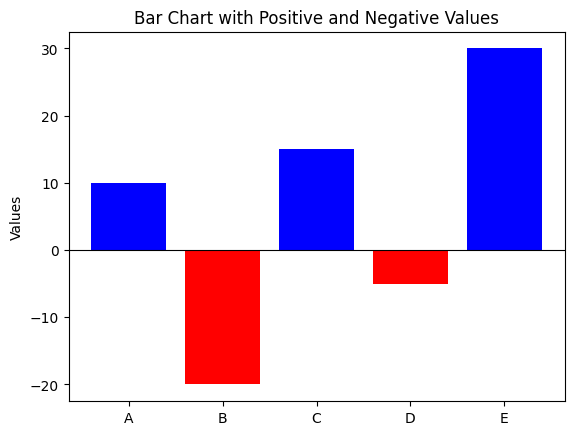

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['A', 'B', 'C', 'D', 'E']
values = [10, -20, 15, -5, 30]

# Set up the figure and axis
fig, ax = plt.subplots()

# Create a bar chart
bars = ax.bar(categories, values, color=['blue' if v >= 0 else 'red' for v in values])

# Add labels and title
ax.set_ylabel('Values')
ax.set_title('Bar Chart with Positive and Negative Values')

# Add a horizontal line at y=0 for reference
ax.axhline(0, color='black', linewidth=0.8)

# Show the chart
plt.show()

## Simulate

In [65]:
import mujoco.viewer
import time

# Debug Nan
# jax.config.update("jax_debug_nans", True)

# Disable tendon
# opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
# mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)

previous_frame_time = time.time()
i = 0
# key = jax.random.key(334)
with mujoco.viewer.launch_passive(mj_model, mj_data) as viewer:
    while viewer.is_running():
        # Update mjx_data from mj_data. The mj_data was modified by the viewer
        # mjx_data = mjx_data.replace(ctrl=mj_data.ctrl, xfrc_applied=mj_data.xfrc_applied)
        # Use the nerual network to generate ctrl signal
        
        mjx_data = mjx_data.replace(xfrc_applied=jp.array(mj_data.xfrc_applied*10, dtype=jp.float32))
        
        # Generate key
        # key = jax.random.split(key,1)[0]
        # xfrc = jax.random.uniform(key,(mjx_model.nbody, 6), minval=-10, maxval=10)
        # mjx_data = mjx_data.replace(xfrc_applied=xfrc)
        mjx_data = mjx_data.replace(
            qpos= jp.array(mj_data.qpos, dtype=jp.float32),
            qvel= jp.array(mj_data.qvel, dtype=jp.float32),
            time = jp.array(mj_data.time, dtype=jp.float32))
        
        # Update mjx_model from mj_model
        mjx_model = mjx_model.tree_replace({
            'opt.gravity': jp.array(mj_model.opt.gravity, dtype=jp.float32),
            'opt.tolerance': jp.array(mj_model.opt.tolerance, dtype=jp.float32),
            'opt.ls_tolerance': jp.array(mj_model.opt.ls_tolerance, dtype=jp.float32),
            'opt.timestep': jp.array(mj_model.opt.timestep, dtype=jp.float32),
        })
        
        
        # Control Muscle
        mjx_data = mjx_data.replace(biomtu = mjx_data.biomtu.replace(act = jp.ones(mjx_model.nbiomtu)*0.05))
        
        mjx_data = mjx_step(mjx_model, mjx_data)
        # mjx_data = jit_multiple_steps(mjx_model, mjx_data)
        # mjx_data, loss, exps = jit_nn_multi_steps(controller_params, mjx_model, mjx_data, key)
        # mjx_data, key, act = jit_nn_mjx_one_step_no_random(controller_params, mjx_model, mjx_data, key)
        
        mjx.get_data_into(mj_data, mj_model, mjx_data)
        
        # Record the current time at the start of this frame
        current_frame_time = time.time()
    
        # Calculate the difference in time from the last frame
        time_between_frames = current_frame_time - previous_frame_time
    
        # Print the time between frames
        print(f"Time between frames: {time_between_frames} seconds")
        previous_frame_time = current_frame_time
        
        # print("ACT:", mjx_data.biomtu.act)
        # print(mjx_data.qpos)
        # print(mj_data.sen)  
        print(mjx_data.sensordata[3:6])
        # print(mjx_data.biomtu.act)
        # print(mjx_data.qfrc_inverse[6], mjx_data.qfrc_inverse[15] )
        # print(mjx_data.qfrc_constraint[6], mjx_data.qfrc_constraint[15])
        # print(len(mjx_data.qvel))
        
        
        viewer.sync()

Time between frames: 0.21419453620910645 seconds
[ 0.     51.7389 -0.0105]
Time between frames: 0.010931253433227539 seconds
[ 107.6783 -345.2327   10.3394]
Time between frames: 0.009314298629760742 seconds
[  42.2264 -135.0384    8.5512]
Time between frames: 0.010825634002685547 seconds
[-27.6221  15.7994  11.8102]
Time between frames: 0.009747505187988281 seconds
[-37.9804 -17.774  -75.2047]
Time between frames: 0.011070489883422852 seconds
[-38.8159  22.9312 -73.5791]
Time between frames: 0.010728120803833008 seconds
[-27.0299  96.0855   9.0601]
Time between frames: 0.010116815567016602 seconds
[-24.5223  39.9586 -44.2674]
Time between frames: 0.01132965087890625 seconds
[ -20.8331  -76.3062 -147.7567]
Time between frames: 0.009911775588989258 seconds
[ -17.5892 -135.9148 -195.1008]
Time between frames: 0.009725093841552734 seconds
[ 141.9378 -178.5043  -25.6289]
Time between frames: 0.01114654541015625 seconds
[  62.355  -165.3499   25.4111]
Time between frames: 0.00909423828125 se

In [ ]:
# Settings
import exp

critic_batch_size = 128*10
controller_batch_size = 128
key = jax.random.key(2024)
keys = jax.random.split(key, controller_batch_size)

memory_settings = exp.memory_settings(critic_batch_size*412, mjx_model.nq*2+mjx_model.nbiomtu*2+mjx_model.nsensordata, mjx_model.nbiomtu, 1)

### Generate initial experience

In [ ]:
exp_pool = None
datas = jax.jit(reset,static_argnames="batch_size")(init_mjx_data, controller_batch_size)
init_data_batch = datas
for i in range(5):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)
    
print(exp_pool.states.shape)

## Prepare Critic gradient

In [ ]:
import optax

v_criticer = jax.vmap(criticer,in_axes=(None, 0))
jit_v_criticer = jax.jit(v_criticer)

def critic_loss(params, batch):
    discount = 0.99
    states = batch.states
    next_states = batch.next_states
    actions = batch.actions
    rewards = batch.rewards
    
    critic_score = v_criticer(params, states)
    target = rewards + discount* jax.lax.stop_gradient(v_criticer(params, next_states))
    # target = rewards + discount* (v_criticer(params, next_states))
    
    loss = optax.l2_loss(critic_score, target)
    loss = jp.mean(loss)
    return loss

sample_batch = exp.memory.sample(exp_pool, critic_batch_size, key)
critic_loss_g_value_lower= jax.jit(jax.value_and_grad(critic_loss)).lower(critic_params, sample_batch)

jit_critic_loss_g_value = critic_loss_g_value_lower.compile()
a=jit_critic_loss_g_value.cost_analysis()[0]['flops']
print(a)

## Test Simple Critic

In [ ]:
def v_criticer(params, states):
    # print(states.shape)
    score = -(states[:,-2]-1.63)**2
    return(score)

## Prepare Actor gradient

In [ ]:
def decay_sum_scan(x, decay):
    def f(sxtm1, xt):
        b = xt + decay * sxtm1
        return b, b
    return jax.lax.scan(f, jp.zeros(x.shape[1:]), x)[1]

def controller_loss_and_experience(controller_params, critic_params, batch, batch_size, mjx_model, init_data_batch, keys):
    # Generate data for simulation
    nq = mjx_model.nq
    nmtu = mjx_model.nbiomtu
    
    # Deal with the done state, reset the done state with init state
    # exp_data_batch = init_data_batch.replace(
    #     qpos = batch.states[:,0:nq], 
    #     qvel = batch.states[:,nq:nq*2],
    #     biomtu = init_data_batch.biomtu.replace(
    #         fiber_l = batch.states[nq*2, nq*2+nmtu],
    #         fiber_v = batch.states[nq*2+nmtu, nq*2+nmtu*2]
    #     ))
    
    qpos = jp.where(batch.dones==1, init_data_batch.qpos, batch.states[:,0:nq])
    qvel = jp.where(batch.dones==1, init_data_batch.qvel, batch.states[:,nq:nq*2])
    fiber_l = jp.where(batch.dones==1, init_data_batch.biomtu.fiber_l, batch.states[:,nq*2 : nq*2+nmtu])
    fiber_v = jp.where(batch.dones==1, init_data_batch.biomtu.fiber_v, batch.states[:,nq*2+nmtu : nq*2+nmtu*2])
    
    # in_data = batch.dones, init_data_batch, exp_data_batch)
    
    in_data = jax.lax.stop_gradient(init_data_batch.replace(
        qpos = qpos,
        qvel = qvel,
        biomtu = init_data_batch.biomtu.replace(
            fiber_l = fiber_l,
            fiber_v = fiber_v)
        )
    )
    
    out_data, keys, new_exps = v_nn_multi_steps(controller_params, mjx_model, in_data, keys)
    # out_states = new_exps.next_states
    # jax.debug.print("out_states shape{0}", out_states.shape)
    out_states = jp.concat([out_data.qpos, out_data.qvel, out_data.biomtu.fiber_l, out_data.biomtu.fiber_v, out_data.sensordata],axis=1)
    critic_score = jp.squeeze(v_criticer(critic_params, out_states))
    decay_M = 0.99 ** jp.arange(new_exps.rewards.shape[1]-1)
    # print(new_exps.rewards.shape)
    loss = -jp.mean(decay_M@new_exps.rewards.T[:-1,:]) - jp.mean(critic_score)
    # loss = -jp.mean(critic_score)
    return loss, new_exps

# The function calculating the loss of the controller and also generate experiences
g_loss_experience = jax.value_and_grad(controller_loss_and_experience, has_aux=True)

controller_keys = jax.random.split(key, controller_batch_size)
sample_batch = exp.memory.sample(exp_pool, controller_batch_size, key)

print("lowering")
g_loss_experience_lower = jax.jit(g_loss_experience, static_argnames=["batch_size"]).lower(
    controller_params, 
    critic_params, 
    sample_batch, 
    controller_batch_size, 
    mjx_model, 
    init_data_batch, 
    controller_keys)

print("compiling")
jit_g_loss_experience = g_loss_experience_lower.compile()

b = jit_g_loss_experience.cost_analysis()[0]['flops']
print(b)

In [ ]:
print(sample_batch.states.shape)
print(b/a)

## Train the two neural networks

In [ ]:
key = jax.random.key(9795)

critic_params, key = critic_nn.init_parameters(key)
critic_tx = optax.apply_if_finite(optax.adam(learning_rate=2e-6), max_consecutive_errors=50)
# critic_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-5), max_consecutive_errors=50)
critic_opt_state = critic_tx.init(critic_params)
jit_critic_tx_update = jax.jit(critic_tx.update)


controller_params, key = controller_nn.init_parameters(key)
controller_tx = optax.apply_if_finite(optax.adam(learning_rate=1e-6), max_consecutive_errors=50)
# controller_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-5), max_consecutive_errors=50)
controller_opt_state = controller_tx.init(controller_params)
jit_controller_tx_update = jax.jit(controller_tx.update)

jit_apply_update = jax.jit(optax.apply_updates)


jit_sample = jax.jit(exp.memory.sample, static_argnames="batch_size")
jit_add_exp = jax.jit(exp.memory.add_exp, static_argnames="settings")



In [ ]:
# Init exp_pool
exp_pool = None
datas = reset(init_mjx_data, controller_batch_size*20)
keys = jax.random.split(key, controller_batch_size*20)
# datas = reset(init_mjx_data, 2)
# keys = jax.random.split(key, 2)
for i in range(3):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    if(i>=0):
        exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)

#plot exp_pool
# plt.plot(exp_pool.states.T[1])
plt.plot(exp_pool.rewards)
# plt.plot(exp_pool.states[0])

In [ ]:
# Debug Nan
# jax.config.update("jax_debug_nans", True)

import exp


death_rate_buf = []
best_death_rate = 0.5

for i in range(4000):

    print("----------",i,"----------")
    criric_repeat = 1
    if(i >= 400):
        criric_repeat = 1
        
    for j in range(criric_repeat):
        batch = jit_sample(exp_pool, critic_batch_size, key)
        key = jax.random.split(key, 1)[0]
        
        # criticer
        critic_loss, critic_loss_grad = jit_critic_loss_g_value(critic_params, batch)
        
        # Update params
        critic_updates, critic_opt_state = jit_critic_tx_update(critic_loss_grad, critic_opt_state)
        critic_params = jit_apply_update(critic_params, critic_updates)
    
    print("criticer loss:",critic_loss)
    # controller
    
    controller_repeat = 1
    # if(i >= 10):
        # controller_repeat = 5
    
    for j in range(controller_repeat):
        keys = jax.random.split(key,controller_batch_size)
        controller_batch = jit_sample(exp_pool, controller_batch_size, key)
        key = jax.random.split(key, 1)[0]
        controller_loss_exps, controller_loss_grad = jit_g_loss_experience(
            controller_params, critic_params, controller_batch, mjx_model, init_data_batch, keys)
        controller_loss = controller_loss_exps[0]
        exps = controller_loss_exps[1]
            
        # Update params
        controller_updates, controller_opt_state = jit_controller_tx_update(controller_loss_grad, controller_opt_state)
        controller_params = jit_apply_update(controller_params, controller_updates)
    
    exp_pool = jit_add_exp(memory_settings, exp_pool, exps)
    
    # Count Dones
    death_rate_buf.insert(0, jp.count_nonzero( exps.dones)/(exps.dones.shape[1]*controller_batch_size))
    death_rate_buf = death_rate_buf[:50]
    death_rate = np.mean(death_rate_buf)
    
    print("Controller Loss:", controller_loss)
    mean_reward = jp.mean(exps.rewards)
    print("mean rewards:", mean_reward)
    mean_score = jp.mean(jit_v_criticer(critic_params, exps.states))
    print("mean score:", mean_score)
    print("scorc/reward:", mean_score/mean_reward)
    print("death rate:", death_rate)
    
    if(best_death_rate > death_rate): best_death_rate = death_rate
    print("best_death_rate:", best_death_rate)
    # add exps
    
    if(i%20 == 0):
        plt.figure()
        plt.plot(exp_pool.rewards)
        plt.plot()
        # plt.plot(exp_pool.rewards)

In [ ]:
# plt.plot(exp_pool.rewards[2000:2200])
# print(exp_pool.states)
test_exp_pool = None
datas = reset(init_mjx_data, 1)
keys = jax.random.split(key, 1)
test_controller_params, key = controller_nn.init_parameters(key)
for i in range(5):
    # datas, keys, exps = jit_v_nn_multi_steps(test_controller_params, mjx_model, datas, keys)
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    if(i>=0):
        test_exp_pool = exp.memory.add_exp(memory_settings, test_exp_pool, exps)
plt.plot(v_criticer(critic_params ,test_exp_pool.states))
plt.plot(test_exp_pool.states[:,-2]*20)
# plt.plot(test_exp_pool.rewards*20-20)

## Visualize the model and controller

In [ ]:
import mujoco.viewer
import time

# Debug Nan
jax.config.update("jax_debug_nans", True)

# Disable tendon
opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)

previous_frame_time = time.time()
i = 0
key = jax.random.key(334)
with mujoco.viewer.launch_passive(mj_model, mj_data) as viewer:
    while viewer.is_running():
        # Update mjx_data from mj_data. The mj_data was modified by the viewer
        # mjx_data = mjx_data.replace(ctrl=mj_data.ctrl, xfrc_applied=mj_data.xfrc_applied)
        # Use the nerual network to generate ctrl signal
        
        mjx_data = mjx_data.replace(xfrc_applied=jp.array(mj_data.xfrc_applied, dtype=jp.float32))
        
        # Generate key
        key = jax.random.split(key,1)[0]
        # xfrc = jax.random.uniform(key,(mjx_model.nbody, 6), minval=-10, maxval=10)
        # mjx_data = mjx_data.replace(xfrc_applied=xfrc)
        mjx_data = mjx_data.replace(
            qpos= jp.array(mj_data.qpos, dtype=jp.float32),
            qvel= jp.array(mj_data.qvel, dtype=jp.float32),
            time = jp.array(mj_data.time, dtype=jp.float32))
        
        # Update mjx_model from mj_model
        mjx_model = mjx_model.tree_replace({
            'opt.gravity': jp.array(mj_model.opt.gravity, dtype=jp.float32),
            'opt.tolerance': jp.array(mj_model.opt.tolerance, dtype=jp.float32),
            'opt.ls_tolerance': jp.array(mj_model.opt.ls_tolerance, dtype=jp.float32),
            'opt.timestep': jp.array(mj_model.opt.timestep, dtype=jp.float32),
        })
        
        # mjx_data = mjx_step(mjx_model, mjx_data)
        # mjx_data, loss, exps = jit_nn_multi_steps(controller_params, mjx_model, mjx_data, key)
        mjx_data, key, act = jit_nn_mjx_one_step_no_random(controller_params, mjx_model, mjx_data, key)
        mjx.get_data_into(mj_data, mj_model, mjx_data)
        
        # Record the current time at the start of this frame
        current_frame_time = time.time()
    
        # Calculate the difference in time from the last frame
        time_between_frames = current_frame_time - previous_frame_time
    
        # Print the time between frames
        print(f"Time between frames: {time_between_frames} seconds")
        previous_frame_time = current_frame_time
        
        # print("ACT:", mjx_data.biomtu.act)
        # print(mjx_data.qpos)
        # print(mj_data.sen)  
        print(mjx_data.sensordata[2])
        print(mjx_data.biomtu.act)
        # print(len(mjx_data.qvel))
        viewer.sync()

In [ ]:
a = [1,2,3,4,5,6,7,8]
b = a[2,3]
print(b)